# Customer Churn Prediction

Dataset yang digunakan pada project ini merupakan dataset *DQLab sport center*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score



## Load Data

In [2]:
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/data_retail.csv', sep=';')
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Sepatu,1406077331494,1545735761270,1269337,41
2,3,3,141526,Tas,1493349147000,1548322802000,310915,30
3,4,4,141526,Jaket,1493362372547,1547643603911,722632,27
4,5,5,37545,Sepatu,1429178498531,1542891221530,1775036,25


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   no                          100000 non-null  int64 
 1   Row_Num                     100000 non-null  int64 
 2   Customer_ID                 100000 non-null  int64 
 3   Product                     100000 non-null  object
 4   First_Transaction           100000 non-null  int64 
 5   Last_Transaction            100000 non-null  int64 
 6   Average_Transaction_Amount  100000 non-null  int64 
 7   Count_Transaction           100000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB


# Data Preparation

### Mengubah kolom `First_Transaction` dan `Last_Transaction` menjadi bentuk datetime

In [4]:
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='1970-01-01')

In [5]:
df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='1970-01-01')

In [6]:
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22
1,2,2,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41
2,3,3,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30
3,4,4,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27
4,5,5,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25


### Melakukan Klasifikasi Pelanggan

Mengklasifikasikan pelanggan apakah berstatus churn atau tidak dan menghapus kolom yang tidak diperlukan (`no` & `Row_Num`)

In [7]:
df.loc[df['Last_Transaction'] <= '2018-08-01', 'is_churn'] = True 
df.loc[df['Last_Transaction'] >= '2018-08-01' , 'is_churn'] = False 

In [8]:
del df['no']
del df['Row_Num']

In [9]:
df.head()

,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction,is_churn
0,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22,False
1,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41,False
2,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30,False
3,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27,False
4,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25,False


## Exploratory Data Analysis

### Customer Acquisition

Menampilkan pelanggan baru tiap tahunnya

In [10]:
df['Year_First_Transaction'] = df['First_Transaction'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year

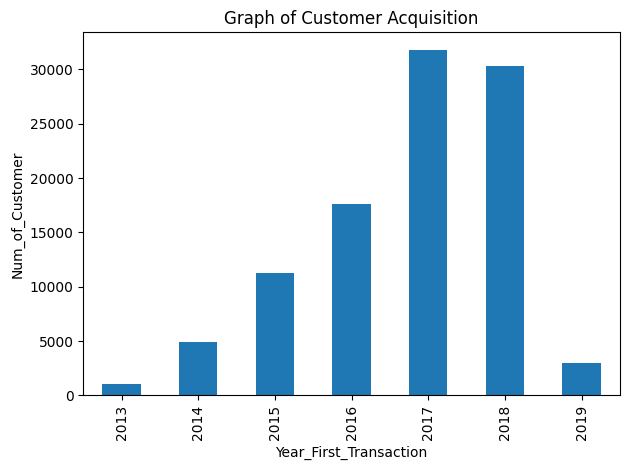

In [11]:
df_year = df.groupby(['Year_First_Transaction'])['Customer_ID'].count()
df_year.plot(x='Year_First_Transaction', y='Customer_ID', kind='bar', title='Graph of Customer Acquisition')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

### Total Transaction

Menampilkan total transaksi yang dilakukan pelanggan tiap tahunnya

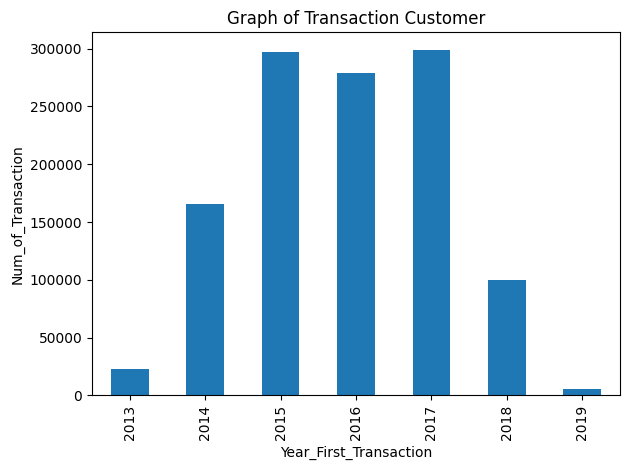

In [12]:
df_year = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
df_year.plot(x='Year_First_Transaction', y='Count_Transaction', kind='bar', title='Graph of Transaction Customer')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Transaction')
plt.tight_layout()
plt.show()

### Average Transaction Amount

Menampilkan tren dari tahun ke tahun rata-rata jumlah transaksi untuk tiap-tiap produknya

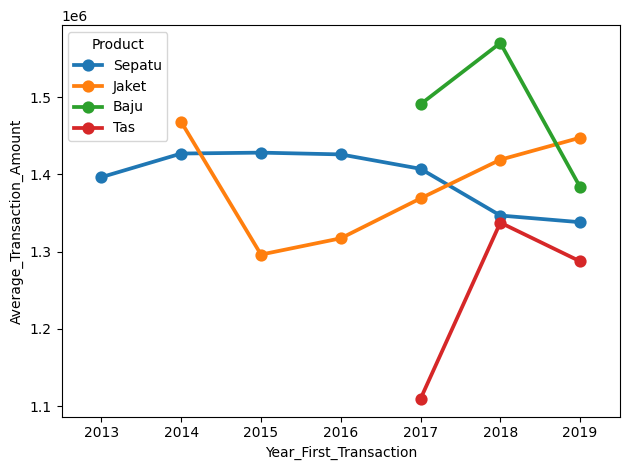

In [13]:
sns.pointplot(data = df.groupby(['Product', 'Year_First_Transaction']).mean().reset_index(), 
              x='Year_First_Transaction', 
              y='Average_Transaction_Amount', 
              hue='Product')
plt.tight_layout()
plt.show()

### Churn Proportion

Menampilkan proporsi pelanggan yang terindentifikasi sebagai churn dan pelanggan yang bukan pada tiap produk

In [14]:
df_piv = df.pivot_table(index='is_churn', 
                        columns='Product',
                        values='Customer_ID', 
                        aggfunc='count', 
                        fill_value=0)

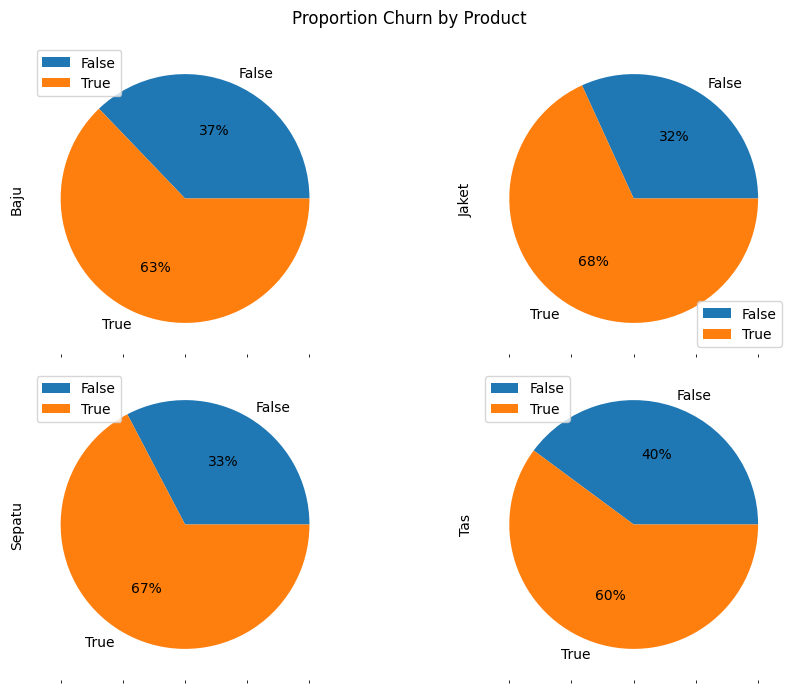

In [15]:
plot_product = df_piv.count().sort_values(ascending=False).head(5).index
df_piv = df_piv.reindex(columns=plot_product)
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion Churn by Product')
plt.tight_layout()
plt.show()

### Customer Distribution

#### Menampilkan distribusi pelanggan berdasarkan `Count_Transaction`

In [16]:
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1. 1'
    elif (row['Count_Transaction'] > 1 and row['Count_Transaction'] <= 3):
        val ='2. 2 - 3'
    elif (row['Count_Transaction'] > 3 and row['Count_Transaction'] <= 6):
        val ='3. 4 - 6'
    elif (row['Count_Transaction'] > 6 and row['Count_Transaction'] <= 10):
        val ='4. 7 - 10'
    else:
        val ='5. > 10'
    return val

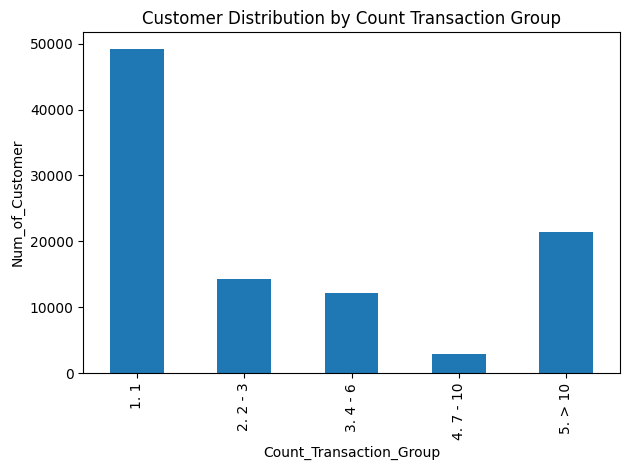

In [17]:
df['Count_Transaction_Group'] = df.apply(func , axis=1)

df_year = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()
df_year.plot(x='Count_Transaction_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaction Group')
plt.xlabel('Count_Transaction_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

* Rentang jumlah transaksi 0 s/d 1    = 1. 1
* Rentang jumlah transaksi 2 s/d 3    = 2. 2 - 3
* Rentang jumlah transaksi 4 s/d 6    = 3. 4 - 6
* Rentang jumlah transaksi 7 s/d 10   = 4. 7 - 10
* Rentang jumlah transaksi > 10       = 5. > 10

#### Menampilkan distribusi pelanggan berdasarkan `Average_Transaction_Amount`

In [18]:
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <= 250000):
        val ='1. 100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <= 500000):
        val ='2. >250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <=750000):
        val ='3. >500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <= 1000000):
        val ='4. >750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val ='5. >1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val ='6. >2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val='7. >5.000.000 - 10.000.000'
    else:
        val ='8. >10.000.000'
    return val

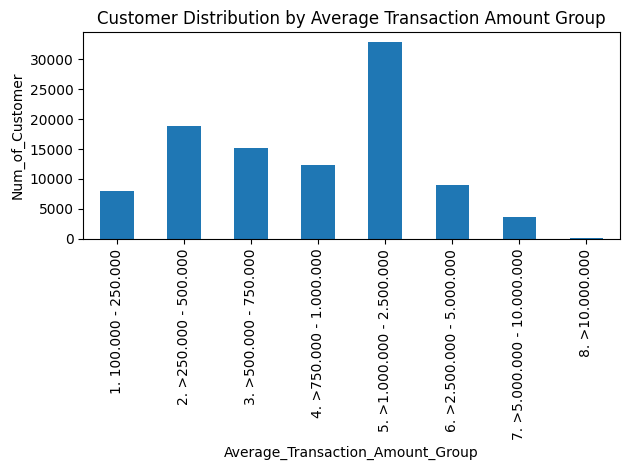

In [19]:
df['Average_Transaction_Amount_Group'] = df.apply(f, axis=1)

df_year = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()
df_year.plot(x='Average_Transaction_Amount_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Average Transaction Amount Group')
plt.xlabel('Average_Transaction_Amount_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

* Rentang rata-rata besar transaksi 100.000 s/d 250.000         = 1. 100.000 - 250.000
* Rentang rata-rata besar transaksi >250.000 s/d 500.000        = 2. >250.000 - 500.000
* Rentang rata-rata besar transaksi >500.000 s/d 750.000        = 3. >500.000 - 750.000
* Rentang rata-rata besar transaksi >750.000 s/d 1.000.000      = 4. >750.000 - 1.000.000
* Rentang rata-rata besar transaksi >1.000.000 s/d 2.500.000    = 5. >1.000.000 - 2.500.000
* Rentang rata-rata besar transaksi >2.500.000 s/d 5.000.000    = 6. >2.500.000 - 5.000.000
* Rentang rata-rata besar transaksi >5.000.000 s/d 10.000.000   = 7. >5.000.000 - 10.000.000
* Rentang rata-rata besar transaksi >10.000.000	                = 8. >10.000.000

## Data Preprocessing

Menentukan kolom feature (X) dan target (y)

In [20]:
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']
X = df[feature_columns]
y = df['is_churn'] 

Melakukan label encode pada target label

In [21]:
le = LabelEncoder()

y = le.fit_transform(y)

In [22]:
le.classes_

array([False, True], dtype=object)

Membagi dataset menjadi 75% training dan 25% testing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (75000, 3)
Shape of y_train: (75000,)
Shape of X_test: (25000, 3)
Shape of y_test: (25000,)


## Data Modelling

Melakukan modelling Logistic Regression, sebelum melakukan Logistic Regression perlu dilakukan inisialisasi model dan fit

In [24]:
# Inisiasi model logreg
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)


LogisticRegression()

In [25]:
# Predict model
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 1, 0])

Melakukan uji kinerja model dengan menggunakan `confusion_matrix` dan menemukan nilai accuracy, precision, dan recall

In [26]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[ 3426  4905]
 [  994 15675]]


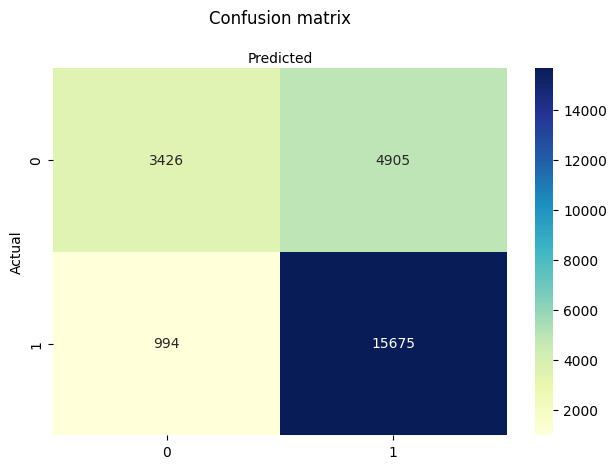

In [27]:
class_names = [0, 1] 
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [28]:
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall   :', recall_score(y_test, y_pred, average='micro'))


Accuracy : 0.76404
Precision: 0.76404
Recall   : 0.76404


## Kesimpulan

* Jaket merupakan produk dengan presentase churn terbesar yaitu 68%
* Kebanyakan customer hanya melakukan sekali transaksi

